# Predict on all merged data

In [140]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import autosklearn.regression
from tpot import TPOTRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import find_peaks


from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters



os.chdir("/home/cernerrood246/University/DataMining")
random_state = 42

#Relevant Models: LR, SVM, LightGBM, CatBoost, XGBoost 

## Feature engineering

In [161]:
participants_list = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17'] 

import numpy as np
from scipy.signal import find_peaks

import numpy as np
from scipy.signal import find_peaks

def calculate_features(data, channels, window):
    all_features = []

    for channel in channels:
        rolling_data = data[channel].rolling(window=window)
        mean = rolling_data.mean()
        std = rolling_data.std()
        skew = rolling_data.skew()
        kurt = rolling_data.kurt()
        median = rolling_data.median()
        min_val = rolling_data.min()
        max_val = rolling_data.max()
        negcount = rolling_data.apply(lambda x: np.sum(x < 0))
        poscount = rolling_data.apply(lambda x: np.sum(x > 0))
        above_mean = rolling_data.apply(lambda x: np.sum(x > x.mean()))
        peaks = rolling_data.apply(lambda x: len(find_peaks(x)[0]))
        energy = rolling_data.apply(lambda x: np.sum(x**2)/100)
        median_abs_dev = rolling_data.apply(lambda x: np.median(np.abs(x - np.median(x))))
        maxmin_diff = rolling_data.apply(lambda x: np.max(x) - np.min(x))
        interq_range = rolling_data.apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

        channel_features = pd.concat([mean, std, skew, kurt, median, min_val, max_val, negcount, poscount, above_mean, peaks, energy, median_abs_dev, maxmin_diff, interq_range], axis=1)
        channel_features.columns = [f'{channel}_{stat}' for stat in ['mean', 'std', 'skew', 'kurt', 'median', 'min', 'max', 'negcount', 'poscount', 'above_mean', 'peaks', 'energy', 'median_abs_dev', 'maxmin_diff', 'interq_range']]
        all_features.append(channel_features)

    features = pd.concat(all_features, axis=1)
    

    return features, list(features.columns)




Merged_all_list = []
for participant in participants_list:
    df = pd.read_pickle(f"merged_dataset/{participant}/ALL_with_earable.pkl") # 
    df['Participant'] = participant
    Merged_all_list.append(df)

feature_Merged_all_list = []
for j, participant_temp in enumerate(Merged_all_list):
    participant = participant_temp.copy()
    #add lag features
    participant.rename(columns={"value__bpm": "valuebpm", "value__confidence" : "valueconfidence"}, inplace=True)
    to_feature_engineer_columns = ["valuebpm", "valueconfidence", "X", "Y", "Z", "Magnitude",]
    to_feature_engineer_columns_with_earable = to_feature_engineer_columns.copy()
    to_feature_engineer_columns_with_earable.extend(['ax', 'ay', 'az', 'gx', 'gy', 'gz'])
    all_columns = to_feature_engineer_columns.copy()
    all_columns.extend(['Activity','BMI', 'Fat', 'Muscle',
       'Water', 'Bone', 'Weight', 'Height', 'Age', 'Gender_F', 'Gender_M', "active energy (kJ)","activity_suggested", "speed", "met_suggested", 'ax', 'ay', 'az', 'gx', 'gy', 'gz',]) 
    #fill missing values 
    participant.ffill(inplace=True)
    participant.bfill(inplace=True)


    if False: #'ax' in participant.columns:
        relevant_colums = to_feature_engineer_columns_with_earable
    else:
        relevant_colums = to_feature_engineer_columns

    extract_features_colums = relevant_colums.copy()
    extract_features_colums.extend(['Time[s]'])

    participant[relevant_colums] = participant[relevant_colums].bfill()
    participant[relevant_colums] = participant[relevant_colums].ffill()
    for column in relevant_colums:
        for i in range(1,10,2):
            participant[f"{column}_lag_{i}"] = participant[column].shift(i)
            all_columns.append(f"{column}_lag_{i}")
            participant[f"{column}_lag_{i}"] = participant[f"{column}_lag_{i}"].bfill()
            participant[f"{column}_lag_{i}"] = participant[f"{column}_lag_{i}"].ffill()

    participant_features = extract_features(participant[extract_features_colums].copy(), column_id='Time[s]',
                    default_fc_parameters = MinimalFCParameters(),
                    n_jobs = 4,
                    )
    new_feature_columns = list(participant_features.columns)
    # merge participant_features with participant 
    participant = participant.merge(participant_features, left_on='Time[s]', right_index=True)

    #features, new_feature_columns = calculate_features(participant, to_feature_engineer_columns, 10)
    # participant = pd.concat([participant, features], axis=1)
    
    feature_Merged_all_list.append(participant)
    print(f"Preprocessed participant : {j+1}/{len(Merged_all_list)}")
    
    

all_columns.extend(new_feature_columns)
all_columns_with_earable = all_columns.copy() 
all_columns = [column_name for column_name in all_columns if column_name not in ['ax', 'ay', 'az', 'gx', 'gy', 'gz',]]
    

Feature Extraction: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Preprocessed participant : 1/17


Feature Extraction: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Preprocessed participant : 2/17


Feature Extraction: 100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Preprocessed participant : 3/17


Feature Extraction: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Preprocessed participant : 4/17


Feature Extraction: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Preprocessed participant : 5/17


Feature Extraction: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Preprocessed participant : 6/17


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


Preprocessed participant : 7/17


Feature Extraction: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Preprocessed participant : 8/17


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Preprocessed participant : 9/17


Feature Extraction: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Preprocessed participant : 10/17


Feature Extraction: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Preprocessed participant : 11/17


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Preprocessed participant : 12/17


Feature Extraction: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Preprocessed participant : 13/17


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Preprocessed participant : 14/17


Feature Extraction: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Preprocessed participant : 15/17


Feature Extraction: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


Preprocessed participant : 16/17


Feature Extraction: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Preprocessed participant : 17/17


In [162]:
all_merged_df = pd.concat(feature_Merged_all_list, axis=0)

#pickle dataframe 
all_merged_df.to_pickle("merged_dataset/all_merged_df_ts_fresh.pkl")
#also save all_columns and all_columns_with_earables

with open("merged_dataset/all_columns_ts_fresh.pkl", "wb") as f:
    pickle.dump(all_columns, f)
with open("merged_dataset/all_columns_with_earable_ts_fresh.pkl", "wb") as f:
    pickle.dump(all_columns_with_earable, f)



#all_merged_df = pd.read_pickle("merged_dataset/all_merged_df_with_features.pkl")
#all_columns = pickle.load(open("merged_dataset/all_columns.pkl", "rb"))
#all_columns_with_earable = pickle.load(open("merged_dataset/all_columns_with_earable.pkl", "rb"))

## Predicting

### Setup

In [163]:
n_splits = 17
scoring_function = "neg_mean_absolute_error"

parameters_17_100 = dict([('colsample_bytree', 0.8919469775949542),
             ('learning_rate', 0.04257327411190523),
             ('max_depth', 3),
             ('min_child_weight', 5.0),
             ('subsample', 0.3)])

parameters_17_30_Earables = dict([('colsample_bytree', 0.6021043213995212),
             ('learning_rate', 0.04411541752514087),
             ('max_depth', 3),
             ('min_child_weight', 5.0),
             ('subsample', 1.0)])

parameters = parameters_17_30_Earables


all_merged_df = pd.concat(feature_Merged_all_list, axis=0)
#drop earables data as it increases error

all_merged_df_selected = all_merged_df[all_columns_with_earable].copy()
#all_merged_df_selected = select_features(all_merged_df[all_columns], all_merged_df["MET"])

X = all_merged_df_selected.to_numpy()
y = all_merged_df["MET"].to_numpy()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Get the list of participants
participants = all_merged_df['Participant']

# Initialize the GroupKFold object
group_kfold = GroupKFold(n_splits=n_splits)
cv=group_kfold.get_n_splits(X, y, participants)

model = XGBRegressor(**parameters, random_state = 42)



In [164]:
cv = [split for split in group_kfold.split(X, y, participants)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)



In [165]:
for i,group in enumerate(cv):
    print(f"Fold {i}")
    print(f"Train size: {group[0].size}")
    print(f"Test size: {group[1].size}")
    print(f"Train participants: {participants.iloc[group[0]].unique()}")
    print(f"Test participants: {participants.iloc[group[1]].unique()}")

Fold 0
Train size: 25854
Test size: 1802
Train participants: ['P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P1']
Fold 1
Train size: 25630
Test size: 2026
Train participants: ['P1' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P2']
Fold 2
Train size: 26159
Test size: 1497
Train participants: ['P1' 'P2' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P3']
Fold 3
Train size: 25836
Test size: 1820
Train participants: ['P1' 'P2' 'P3' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P4']
Fold 4
Train size: 25937
Test size: 1719
Train participants: ['P1' 'P2' 'P3' 'P4' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P5']
Fold 5
Train size: 26006
Test size: 1650
Train participants: ['P1' 'P2' 'P3' 'P4' 'P5' 'P7' 'P8' 'P9' 'P10' 'P

### Simple

In [166]:
# Perform cross-validation and calculate mean squared error
scores = cross_val_score(model, X, y, cv=cv, scoring=scoring_function, n_jobs=-1)
print("Cross-validation scores:", -scores)
mae = -scores.mean()

print("Mean absolute error:", mae)

#0.8157495903888696
#0.7490138598598445
#0.7632748586909164 with earable
#[0.62398211 1.00243242 1.50665608 0.38611262 0.62106821 0.86445891 0.62474281 0.85980616 0.54941665 0.45461692 0.52059886 1.44542259 0.75120969 0.14797707 0.91302952 0.5717947  1.13234727]
# 0.726761197118895 without, 0.7170501371310506 with earable and tuning for earable
# 0.7632748586909164 with and bit bietter without with other tuning

Cross-validation scores: [0.57286571 0.9624727  1.46606699 0.43302764 0.5791851  0.92490107
 0.50990727 0.70408322 0.51763312 0.3745642  0.56723967 1.26062176
 0.64806488 0.14354581 0.81501699 0.62869957 1.08195664]
Mean absolute error: 0.7170501371310506


In [56]:
earables_scores = -scores
earables_scores

array([0.57286571, 0.9624727 , 1.46606699, 0.43302764, 0.5791851 ,
       0.92490107, 0.50990727, 0.70408322, 0.51763312, 0.3745642 ,
       0.56723967, 1.26062176, 0.64806488, 0.14354581, 0.81501699,
       0.62869957, 1.08195664])

In [57]:
without_earables = -scores

In [58]:
earables_scores - without_earables

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {    
        'max_depth': [2,3,7],
        'min_child_weight': [0.3,0.5, 2],
        'subsample': [0.3, 0.5],
        'colsample_bytree': [0.6,0.8],
        'learning_rate':[0.03, 0.05, 0.07],
    }
clf = GridSearchCV(XGBRegressor(random_state = 42), parameters, cv=group_kfold.get_n_splits(X, y, participants), scoring=scoring_function, n_jobs=-1, verbose=3)
clf.fit(X, y)

print("val. score: %s" % clf.best_score_)
sorted(clf.cv_results_.keys())

In [ ]:
clf.cv_results_["params"]

In [155]:
opt = BayesSearchCV(
    XGBRegressor(random_state = 42),
    {
        'max_depth': Integer(3, 7),
        'min_child_weight': Real(0.5, 5),
        'subsample': Real(0.3, 1),
        'colsample_bytree': Real(0.01, 1),
        'learning_rate':Real(0.01, 1),
    },
    n_iter=30,
    cv=cv,
    scoring = scoring_function,
    verbose = 2,
    n_jobs=-1

)

opt.fit(X, y)
print("val. score: %s" % opt.best_score_)

Fitting 17 folds for each of 1 candidates, totalling 17 fits
[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.516013307391814, subsample=0.6108688508664266; total time=   6.9s
[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.516013307391814, subsample=0.6108688508664266; total time=   7.1s
[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.516013307391814, subsample=0.6108688508664266; total time=   7.1s
[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.516013307391814, subsample=0.6108688508664266; total time=   7.2s
[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.516013307391814, subsample=0.6108688508664266; total time=   7.1s
[CV] END colsample_bytree=0.5466306241864516, learning

/home/cernerrood246/anaconda3/envs/DM_3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
18903.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.516013307391814, subsample=0.6108688508664266; total time=   7.5s
[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.516013307391814, subsample=0.6108688508664266; total time=   7.7s
[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.516013307391814, subsample=0.6108688508664266; total time=   7.7s
[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.516013307391814, subsample=0.6108688508664266; total time=   7.7s
[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.516013307391814, subsample=0.6108688508664266; total time=   7.7s
[CV] END colsample_bytree=0.5466306241864516, learning_rate=0.522354349991666, max_depth=5, min_child_weight=4.5160

/home/cernerrood246/anaconda3/envs/DM_3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.676801705280961, learning_rate=0.695717685134821, max_depth=4, min_child_weight=0.8619259756150568, subsample=0.8259106800786153; total time=   5.8s
[CV] END colsample_bytree=0.676801705280961, learning_rate=0.695717685134821, max_depth=4, min_child_weight=0.8619259756150568, subsample=0.8259106800786153; total time=   5.9s
[CV] END colsample_bytree=0.676801705280961, learning_rate=0.695717685134821, max_depth=4, min_child_weight=0.8619259756150568, subsample=0.8259106800786153; total time=   5.9s


19085.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END colsample_bytree=0.676801705280961, learning_rate=0.695717685134821, max_depth=4, min_child_weight=0.8619259756150568, subsample=0.8259106800786153; total time=   7.8s
[CV] END colsample_bytree=0.676801705280961, learning_rate=0.695717685134821, max_depth=4, min_child_weight=0.8619259756150568, subsample=0.8259106800786153; total time=   8.1s
[CV] END colsample_bytree=0.676801705280961, learning_rate=0.695717685134821, max_depth=4, min_child_weight=0.8619259756150568, subsample=0.8259106800786153; total time=   8.1s
[CV] END colsample_bytree=0.676801705280961, learning_rate=0.695717685134821, max_depth=4, min_child_weight=0.8619259756150568, subsample=0.8259106800786153; total time=   5.8s
[CV] END colsample_bytree=0.676801705280961, learning_rate=0.695717685134821, max_depth=4, min_child_weight=0.8619259756150568, subsample=0.8259106800786153; total time=   5.7s
[CV] END colsample_bytree=0.676801705280961, learning_rate=0.695717685134821, max_depth=4, min_child_weight=0.86192

/home/cernerrood246/anaconda3/envs/DM_3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.3401232594112243, learning_rate=0.09110995361170979, max_depth=6, min_child_weight=0.9584525931284068, subsample=1.0; total time=   6.7s


19426.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END colsample_bytree=0.3401232594112243, learning_rate=0.09110995361170979, max_depth=6, min_child_weight=0.9584525931284068, subsample=1.0; total time=   7.3s
[CV] END colsample_bytree=0.3401232594112243, learning_rate=0.09110995361170979, max_depth=6, min_child_weight=0.9584525931284068, subsample=1.0; total time=   7.0s
[CV] END colsample_bytree=0.3401232594112243, learning_rate=0.09110995361170979, max_depth=6, min_child_weight=0.9584525931284068, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=0.3401232594112243, learning_rate=0.09110995361170979, max_depth=6, min_child_weight=0.9584525931284068, subsample=1.0; total time=   5.1s
Fitting 17 folds for each of 1 candidates, totalling 17 fits
[CV] END colsample_bytree=0.9927377841671232, learning_rate=0.07601966326294429, max_depth=7, min_child_weight=4.82015324195056, subsample=0.9169053578122905; total time=  18.5s
[CV] END colsample_bytree=0.9927377841671232, learning_rate=0.07601966326294429, max_depth=7, min_chi

/home/cernerrood246/anaconda3/envs/DM_3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.9927377841671232, learning_rate=0.07601966326294429, max_depth=7, min_child_weight=4.82015324195056, subsample=0.9169053578122905; total time=  17.4s


19496.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END colsample_bytree=0.9927377841671232, learning_rate=0.07601966326294429, max_depth=7, min_child_weight=4.82015324195056, subsample=0.9169053578122905; total time=  16.7s
[CV] END colsample_bytree=0.9927377841671232, learning_rate=0.07601966326294429, max_depth=7, min_child_weight=4.82015324195056, subsample=0.9169053578122905; total time=  18.7s
[CV] END colsample_bytree=0.9927377841671232, learning_rate=0.07601966326294429, max_depth=7, min_child_weight=4.82015324195056, subsample=0.9169053578122905; total time=  17.6s
[CV] END colsample_bytree=0.9927377841671232, learning_rate=0.07601966326294429, max_depth=7, min_child_weight=4.82015324195056, subsample=0.9169053578122905; total time=  14.4s
[CV] END colsample_bytree=0.9927377841671232, learning_rate=0.07601966326294429, max_depth=7, min_child_weight=4.82015324195056, subsample=0.9169053578122905; total time=  11.4s
Fitting 17 folds for each of 1 candidates, totalling 17 fits
[CV] END colsample_bytree=0.01, learning_rate=0.1

/home/cernerrood246/anaconda3/envs/DM_3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
19697.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END colsample_bytree=0.4173587833059488, learning_rate=0.0797610815004299, max_depth=7, min_child_weight=1.508145462340908, subsample=0.8846923937623288; total time=  10.7s
[CV] END colsample_bytree=0.4173587833059488, learning_rate=0.0797610815004299, max_depth=7, min_child_weight=1.508145462340908, subsample=0.8846923937623288; total time=  10.6s
[CV] END colsample_bytree=0.4173587833059488, learning_rate=0.0797610815004299, max_depth=7, min_child_weight=1.508145462340908, subsample=0.8846923937623288; total time=  11.2s
[CV] END colsample_bytree=0.4173587833059488, learning_rate=0.0797610815004299, max_depth=7, min_child_weight=1.508145462340908, subsample=0.8846923937623288; total time=  11.5s
[CV] END colsample_bytree=0.4173587833059488, learning_rate=0.0797610815004299, max_depth=7, min_child_weight=1.508145462340908, subsample=0.8846923937623288; total time=  11.6s
[CV] END colsample_bytree=0.4173587833059488, learning_rate=0.0797610815004299, max_depth=7, min_child_weight=

In [26]:
opt.best_params_

OrderedDict([('colsample_bytree', 0.6021043213995212),
             ('learning_rate', 0.04411541752514087),
             ('max_depth', 3),
             ('min_child_weight', 5.0),
             ('subsample', 1.0)])

In [8]:
all_merged_df_selected.columns

Index(['valuebpm', 'valueconfidence_lag_1', 'valueconfidence_lag_3',
       'valueconfidence_lag_5', 'valueconfidence_lag_7',
       'valueconfidence_lag_9', 'valueconfidence__median',
       'valueconfidence__minimum', 'valueconfidence__absolute_maximum',
       'valuebpm_lag_9', 'valueconfidence__maximum', 'valuebpm__sum_values',
       'valuebpm__median', 'valuebpm__mean', 'valuebpm__root_mean_square',
       'valuebpm__maximum', 'valuebpm__absolute_maximum', 'valuebpm__minimum',
       'valueconfidence__sum_values', 'valueconfidence__root_mean_square',
       'valuebpm_lag_7', 'valueconfidence__mean', 'valuebpm_lag_3',
       'valuebpm_lag_1', 'met_suggested', 'speed', 'activity_suggested',
       'active energy (kJ)', 'valueconfidence', 'Activity', 'valuebpm_lag_5',
       'Y__absolute_maximum', 'Y__root_mean_square', 'Z__absolute_maximum',
       'Z__root_mean_square', 'Y__maximum', 'Y', 'Y__mean', 'Y__sum_values',
       'Y__median', 'Y__minimum', 'Y_lag_1', 'Y_lag_3', 'Y_lag_5'

### Analytics

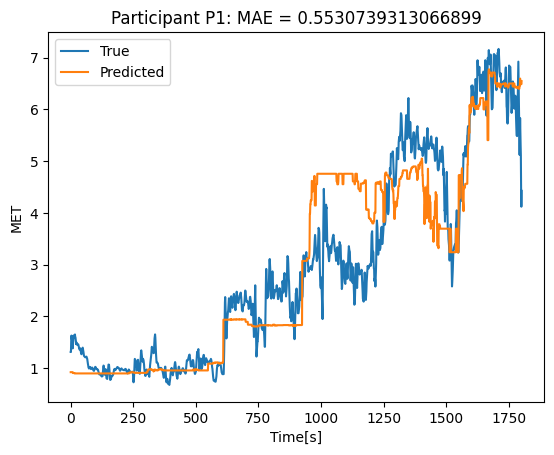

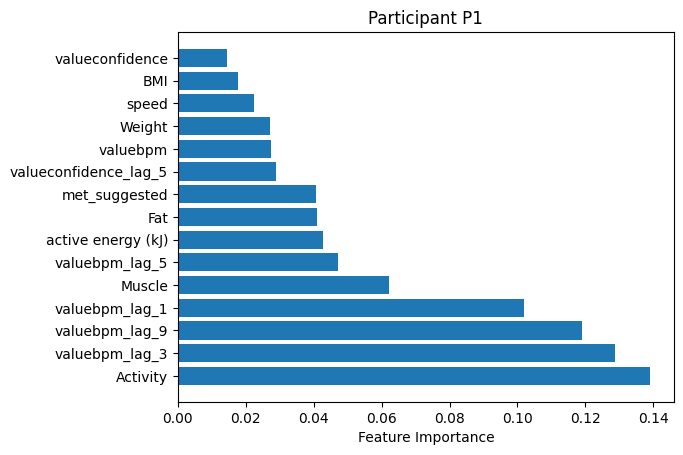

mean MET: true = 2.965399624717587 predicted = 2.9926702976226807, mae =0.02727067290509355


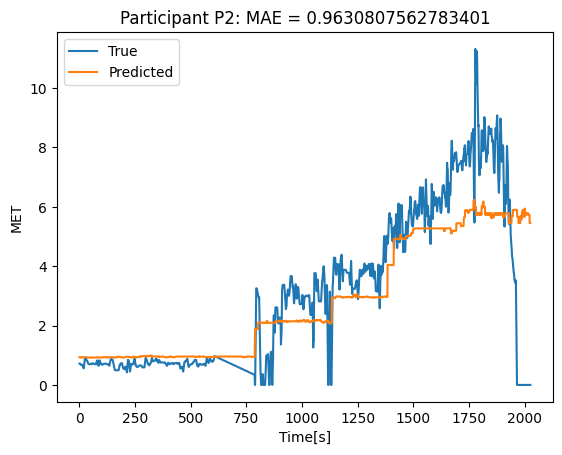

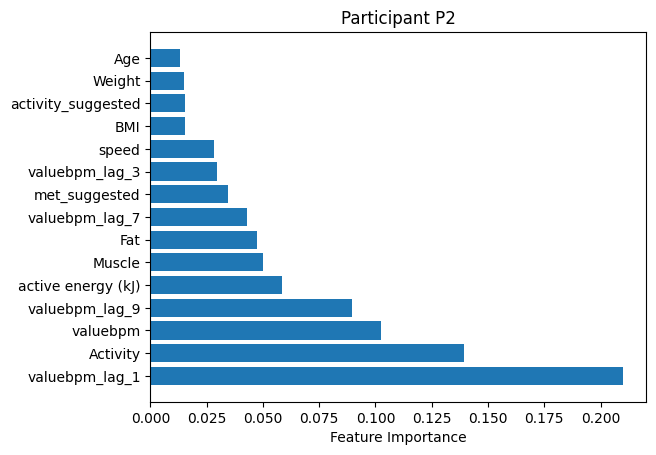

mean MET: true = 3.0429846431393215 predicted = 2.8119754791259766, mae =0.23100916401334493


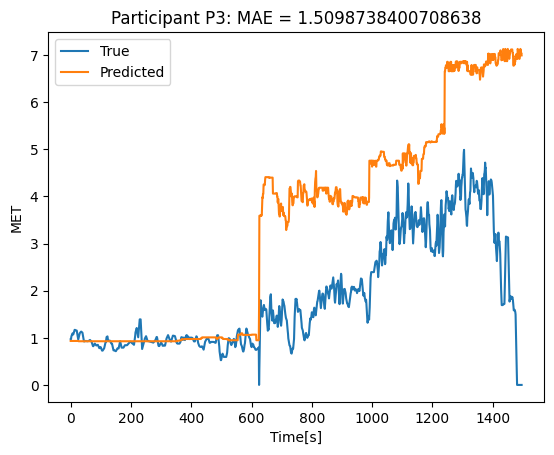

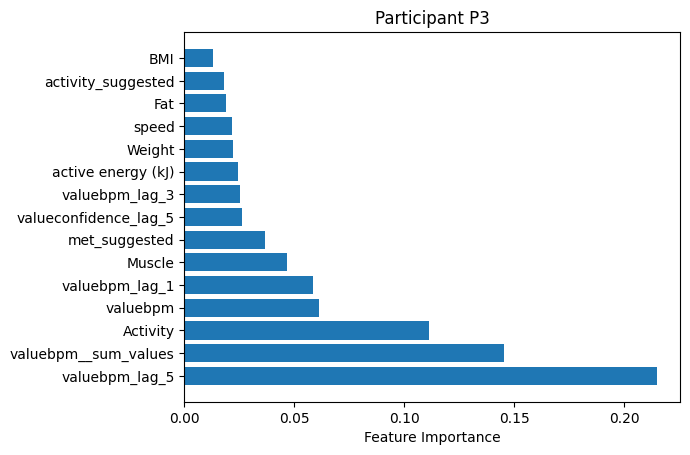

mean MET: true = 1.8743836065766502 predicted = 3.3568713665008545, mae =1.4824877599242043


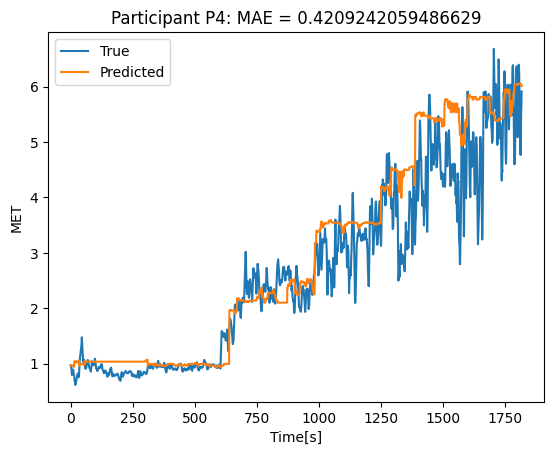

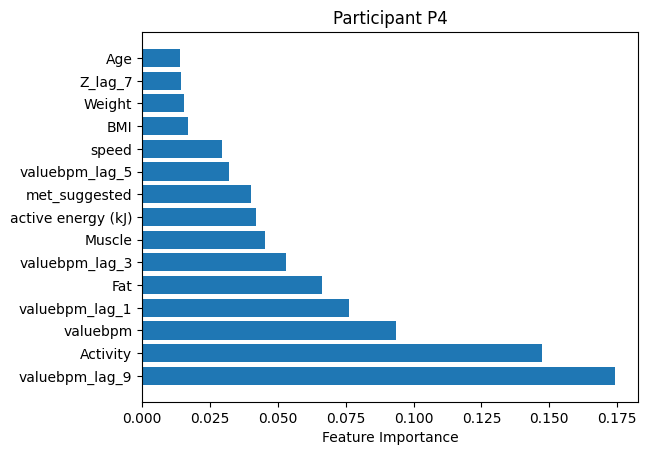

mean MET: true = 2.659827527324808 predicted = 2.945133924484253, mae =0.2853063971594447


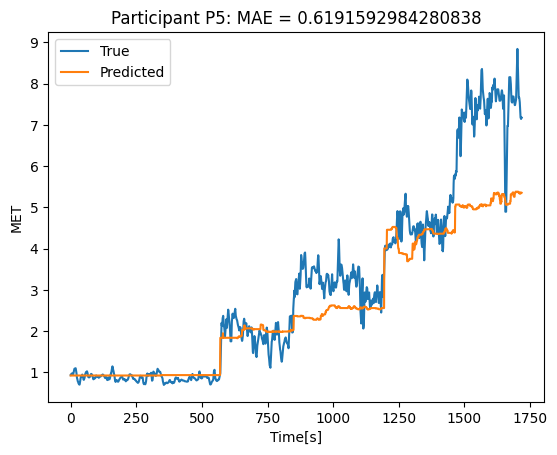

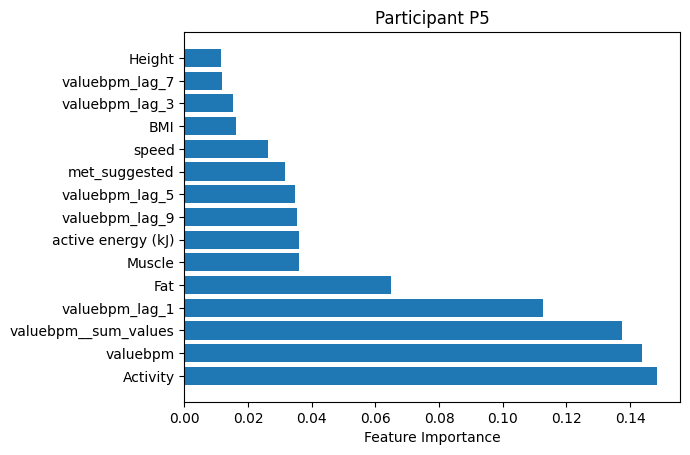

mean MET: true = 3.0410911026147316 predicted = 2.553231954574585, mae =0.48785914804014663


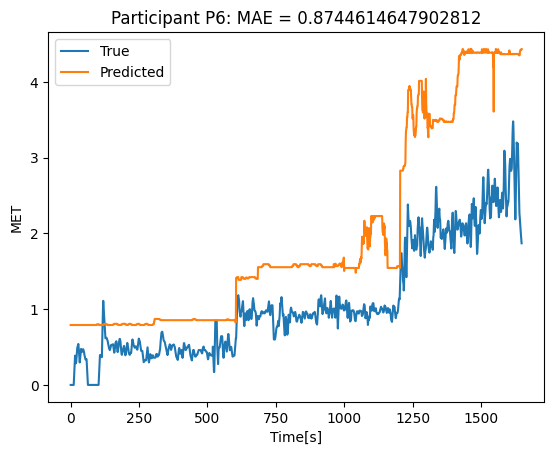

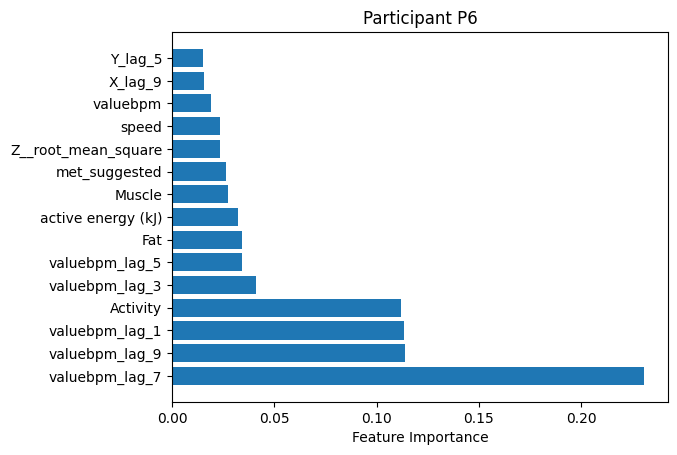

mean MET: true = 1.0911265431754757 predicted = 1.9640917778015137, mae =0.8729652346260379


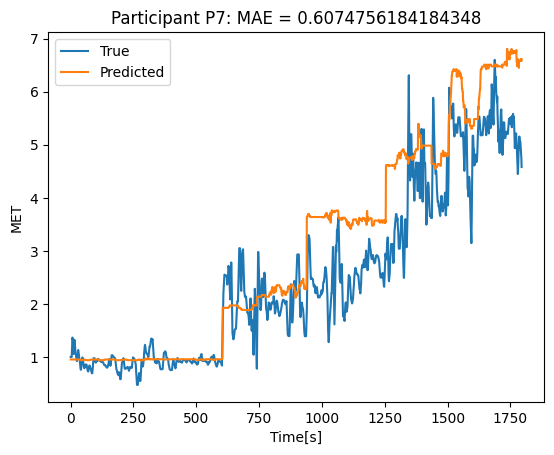

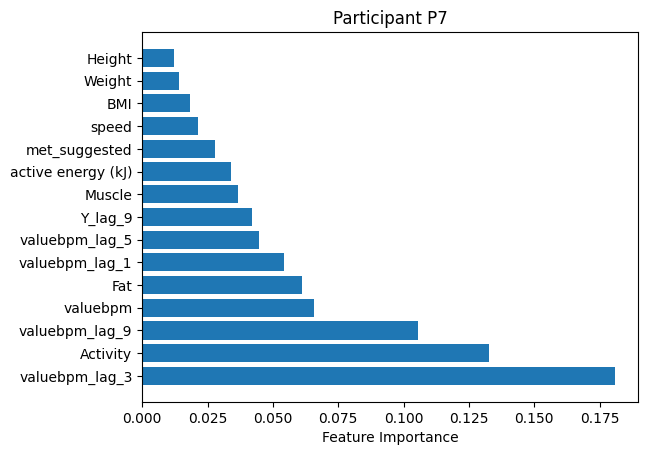

mean MET: true = 2.5248162547852937 predicted = 3.0288314819335938, mae =0.5040152271483


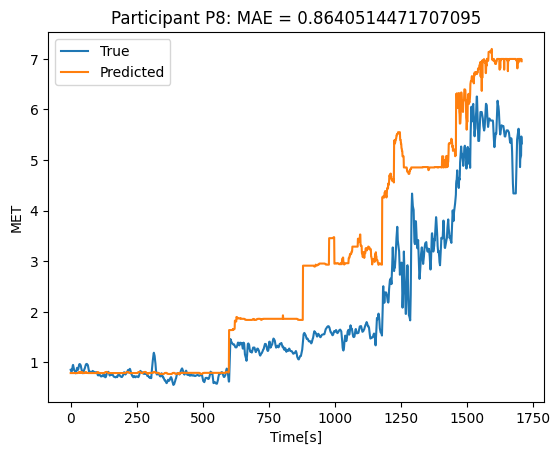

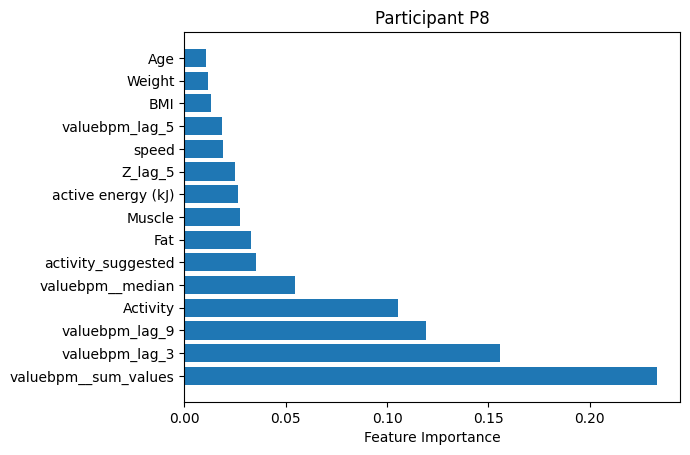

mean MET: true = 2.0575034762077444 predicted = 2.9066383838653564, mae =0.849134907657612


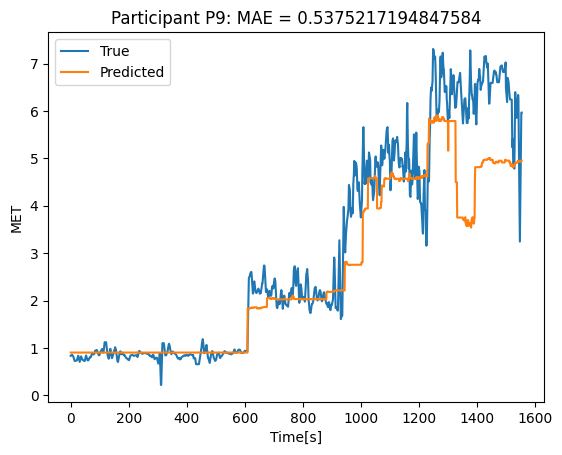

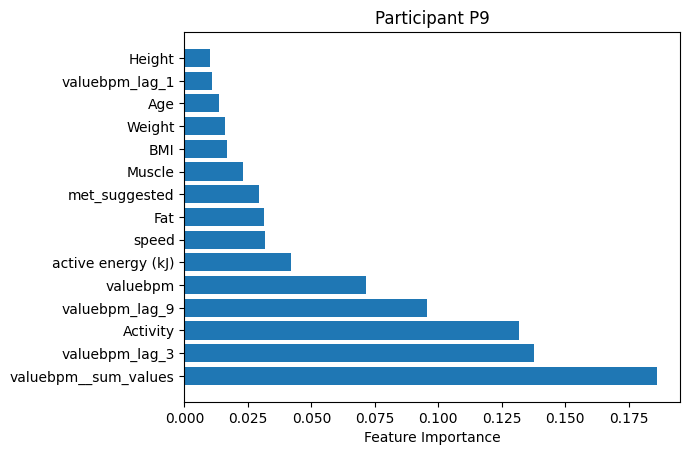

mean MET: true = 2.9857805508248747 predicted = 2.5746243000030518, mae =0.41115625082182294


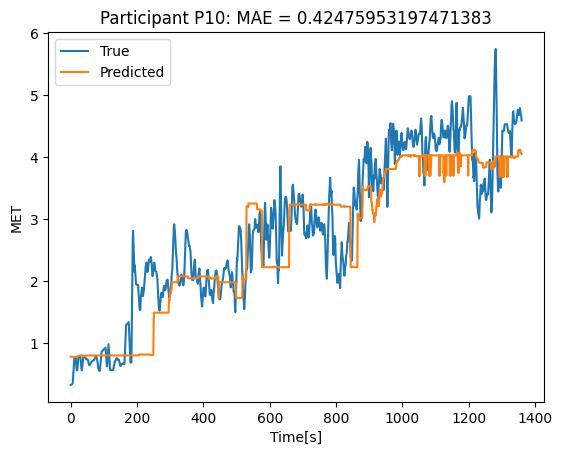

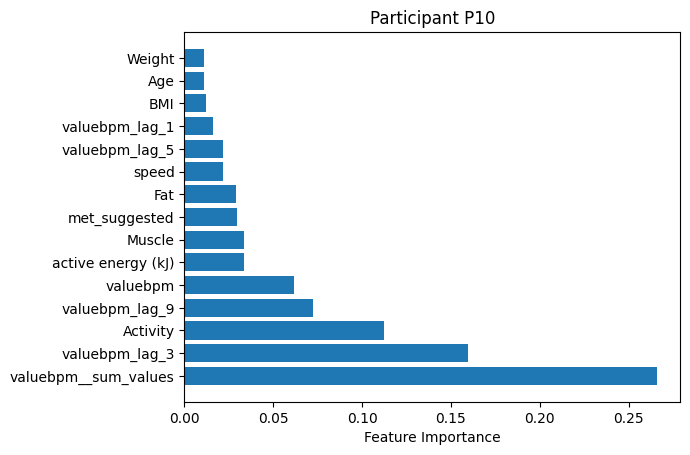

mean MET: true = 2.8312401419716986 predicted = 2.6653800010681152, mae =0.16586014090358336


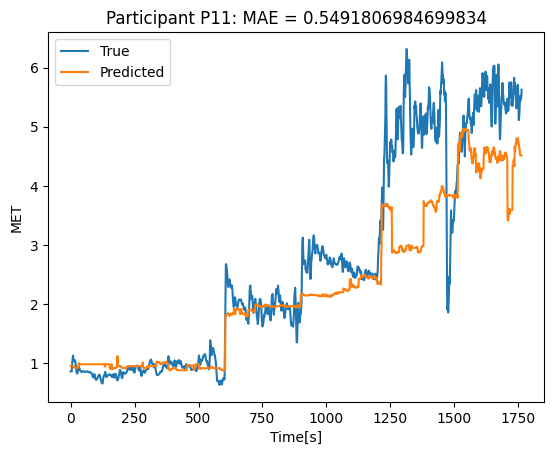

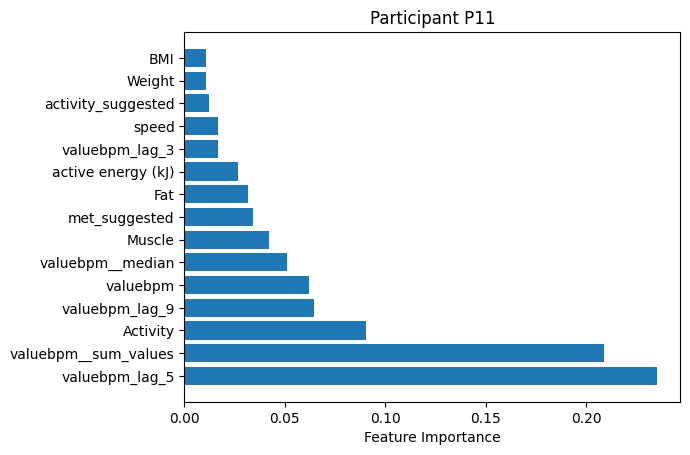

mean MET: true = 2.691007514268926 predicted = 2.2633392810821533, mae =0.4276682331867727


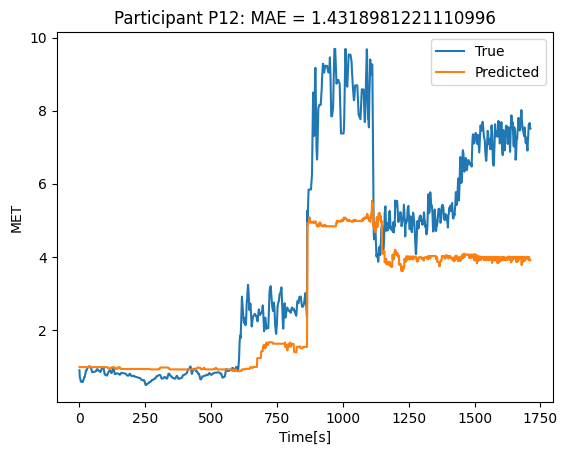

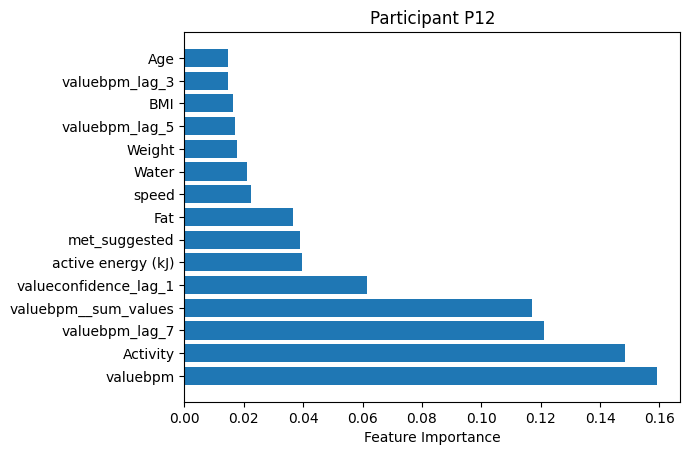

mean MET: true = 3.9616551753895375 predicted = 2.6680901050567627, mae =1.2935650703327748


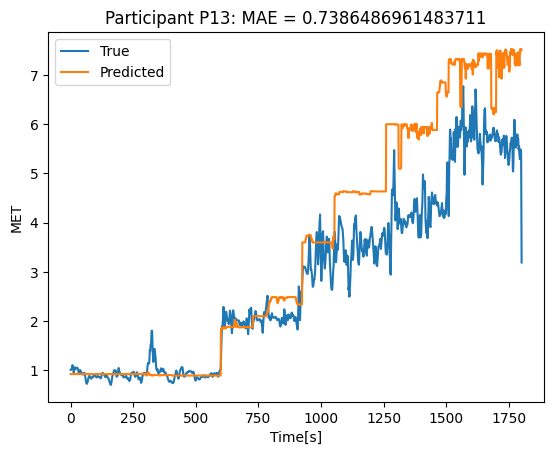

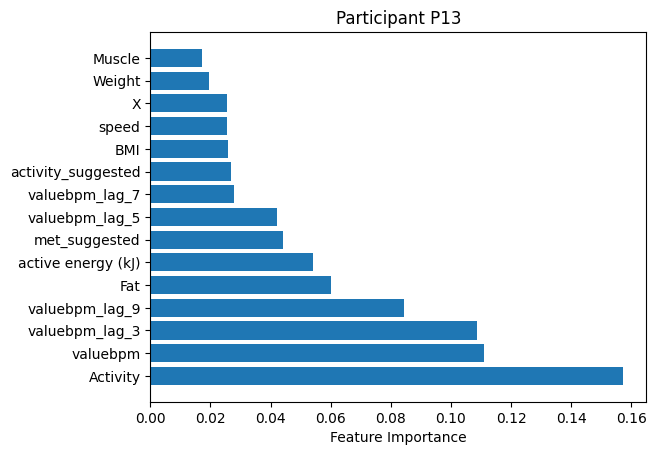

mean MET: true = 2.814999325167751 predicted = 3.489631175994873, mae =0.6746318508271218


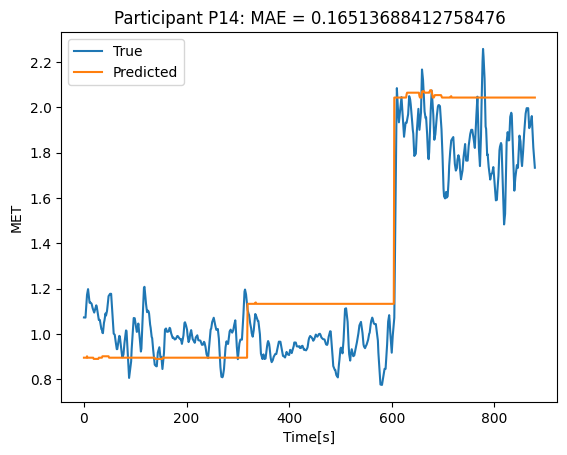

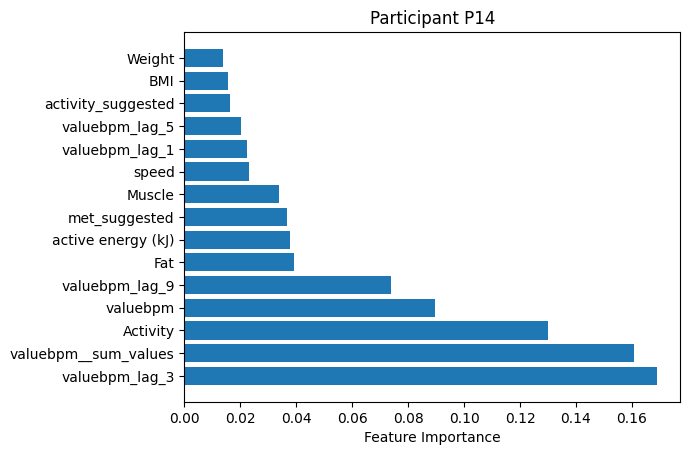

mean MET: true = 1.2521494472261814 predicted = 1.3325906991958618, mae =0.08044125196968044


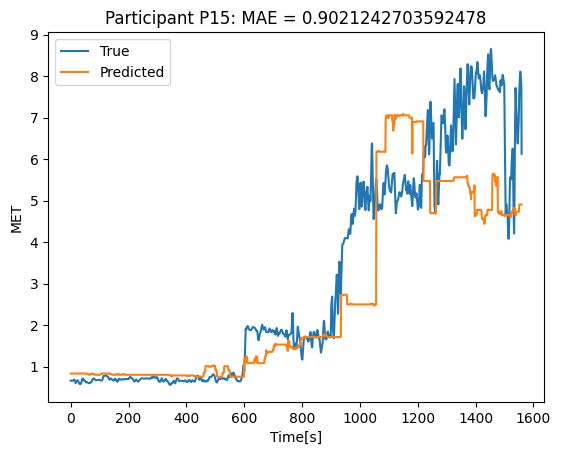

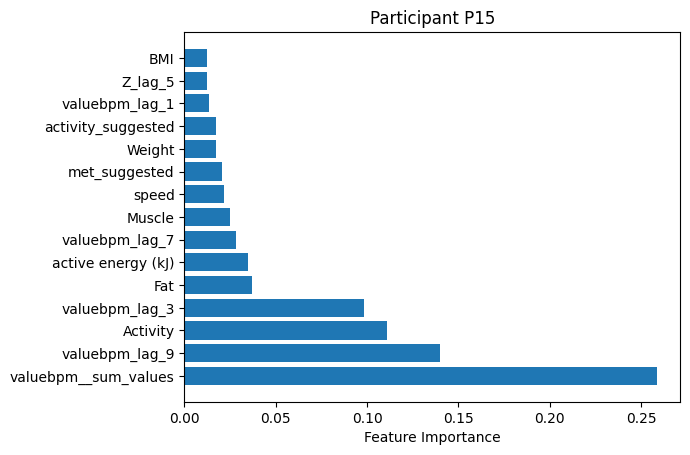

mean MET: true = 3.107075894050837 predicted = 2.657625913619995, mae =0.44944998043084183


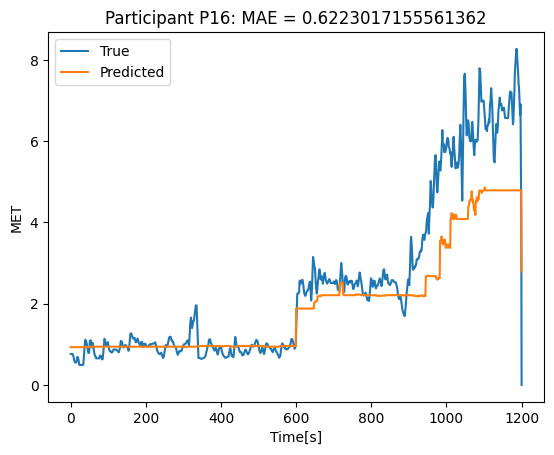

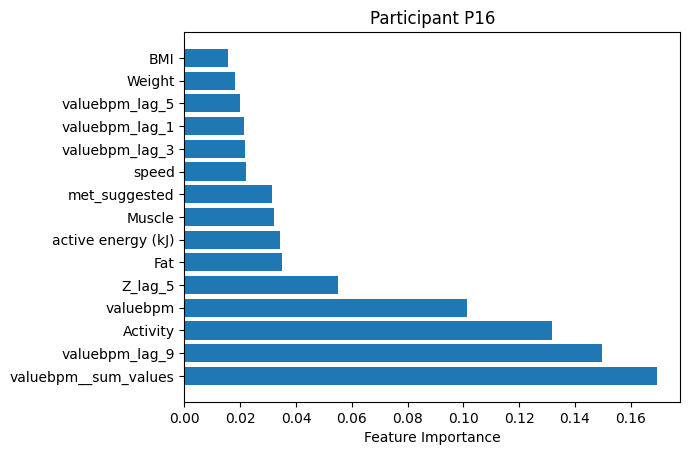

mean MET: true = 2.4935408381968642 predicted = 1.9812424182891846, mae =0.5122984199076797


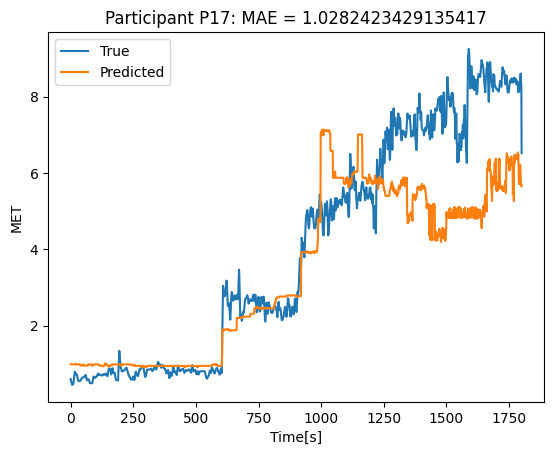

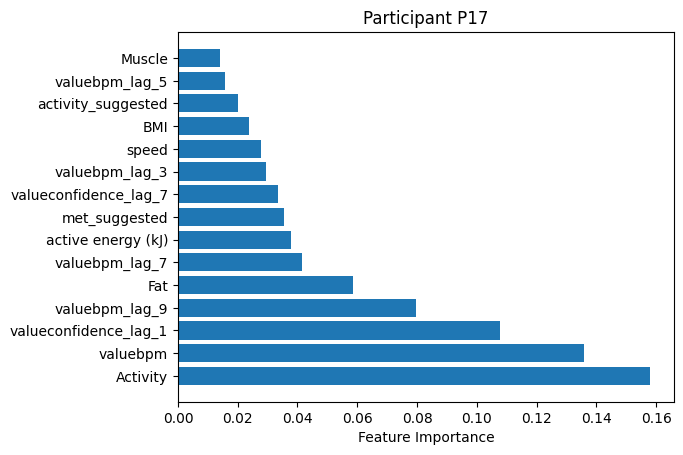

mean MET: true = 4.0317177435362535 predicted = 3.4046506881713867, mae =0.6270670553648667


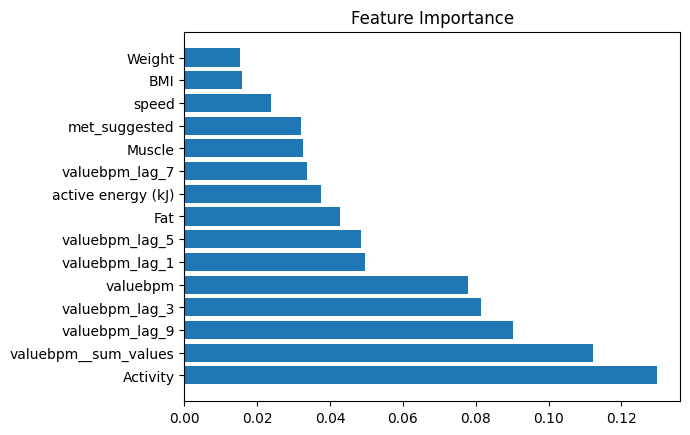

In [67]:
n_top_features = 15
mae_participants = []

feature_importances_all = np.zeros(X.shape[1])
for fold, participant in zip(cv, participants_list):
    X_train, X_test = X[fold[0]], X[fold[1]]
    y_train, y_test = y[fold[0]], y[fold[1]]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    plt.plot(y_test)
    plt.plot(y_pred)
    plt.title(f"Participant {participant}: MAE = {mae}")
    plt.legend(["True", "Predicted"])
    plt.xlabel("Time[s]")
    plt.ylabel("MET")
    plt.show()

    feature_importances_all += model.feature_importances_
    sorted_idx = model.feature_importances_.argsort()[::-1]
    plt.barh(all_merged_df_selected.columns[sorted_idx][:n_top_features], model.feature_importances_[sorted_idx][:n_top_features])
    plt.xlabel("Feature Importance")
    plt.title(f"Participant {participant}")

    plt.show()

    print(f"mean MET: true = {y_test.mean()} predicted = {y_pred.mean()}, mae ={mean_absolute_error([y_test.mean()],[y_pred.mean()])}")
    mae_participants.append(mae)

    
    
feature_importances_all /= len(participants_list)
sorted_idx = feature_importances_all.argsort()[::-1]
plt.barh(all_merged_df_selected.columns[sorted_idx][:n_top_features], feature_importances_all[sorted_idx][:n_top_features])
plt.title("Feature Importance")
plt.show()


Text(0.5, 1.0, 'Sensor Importance')

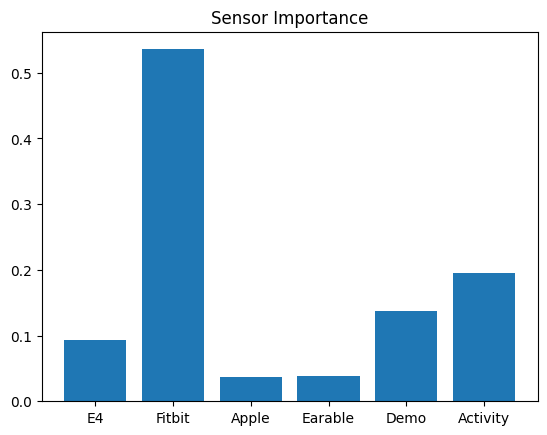

In [68]:
E4_features = ["X", "Y", "Z", "Magnitude"]
Fitbit_features = ["valuebpm", "valueconfidence"]
Apple_features = ["active energy (kJ)"]
Earable_features = ['ax', 'ay', 'az', 'gx', 'gy', 'gz',]
Demo_features = ['BMI', 'Fat', 'Muscle','Water', 'Bone', 'Weight', 'Height', 'Age', 'Gender_F', 'Gender_M']
Activity_features = ['Activity', "activity_suggested", "speed", "met_suggested"]

E_4_indexes = []
Fitbit_indexes = []
Apple_indexes = []
Earable_indexes = []
Demo_indexes = []
Activity_indexes = []

#get all colums that contain the string
for i,column in enumerate(all_merged_df_selected.columns):
    for feature in E4_features:
        if feature in column:
            E_4_indexes.append(i)
    for feature in Fitbit_features:
        if feature in column:
            Fitbit_indexes.append(i)
    for feature in Apple_features:
        if feature in column:
            Apple_indexes.append(i)
    
    #comment out sometimes
    for feature in Earable_features:
        if feature in column:
            Earable_indexes.append(i)
    for feature in Demo_features:
        if feature in column:
            Demo_indexes.append(i)
    for feature in Activity_features:
        if feature in column:
            Activity_indexes.append(i)



lables = ["E4", "Fitbit", "Apple", "Earable", "Demo", "Activity"]
summed_contributions = [feature_importances_all[E_4_indexes].sum(), feature_importances_all[Fitbit_indexes].sum(), feature_importances_all[Apple_indexes].sum(), feature_importances_all[Earable_indexes].sum(), feature_importances_all[Demo_indexes].sum(), feature_importances_all[Activity_indexes].sum()]

plt.bar(lables, summed_contributions)
plt.title("Sensor Importance")



In [39]:
#correlate with demographics 

demographics = pd.read_pickle("preprocessed_dataset/demographics.pkl")
demographics["mae"] = mae_participants

demographics.corr()["mae"]

BMI        -0.183515
Fat        -0.355621
Muscle      0.545326
Water       0.582761
Bone        0.750601
Weight      0.005740
Height      0.314632
Age        -0.170827
Gender_F   -0.177138
Gender_M    0.177138
mae         1.000000
Name: mae, dtype: float64

## Archive

In [ ]:
# List of models to evaluate, set LGMB to not output info

models = [XGBRegressor()] #LinearRegression(), SVR(), LGBMRegressor(verbose=-1), CatBoostRegressor(verbose=0),
names = ["XGBoost"] #"Linear Regression", "Support Vector Machine", "LightGBM", "CatBoost", 
models_tuned = dict()

# Perform operations for each model
for model,name in zip(models, names):
    model.fit(X_train_scaled, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Mean Squared Error: {mse}")
    models_tuned[name] = model


In [ ]:
participant = "P3"

X_train, X_test, y_train, y_test = all_merged_df[all_merged_df["Participant"] != participant][X_columns].to_numpy(), all_merged_df[all_merged_df["Participant"] == participant][X_columns].to_numpy(), all_merged_df[all_merged_df["Participant"] != participant]["MET"].to_numpy(), all_merged_df[all_merged_df["Participant"] == participant]["MET"].to_numpy()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = XGBRegressor()
model.fit(X_train_scaled, y_train)
    
# Predict on test data
y_pred = model.predict(X_test_scaled)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"{name} Mean Squared Error: {mse}")


In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
)
# Fit the AutoSklearnRegressor
automl.fit(X_train_scaled, y_train)

# Get the predicted values
y_pred = automl.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"AutoSklearn Mean Squared Error: {mse}")

In [ ]:
# Define the TPOTRegressor
tpot = TPOTRegressor(generations=3, population_size=10, verbosity=2, random_state=42, cv = group_kfold.get_n_splits(X, y, participants))

# Fit the TPOTRegressor
tpot.fit(X, y)

# # Get the predicted values
# y_pred = tpot.predict(X_test_scaled)

# # Calculate the mean squared error
# mse = mean_squared_error(y_test, y_pred)
# print(f"TPOT Mean Squared Error: {mse}")
